In [2]:
import matplotlib.pyplot as plt

# unused but required import for doing 3d projections with matplotlib < 3.2
import mpl_toolkits.mplot3d  # noqa: F401
from matplotlib import ticker

from sklearn import manifold

import numpy as np
from skimage.transform import resize
from skimage.morphology import area_closing

In [3]:
def image_resize(img, sz):
    return resize(img, sz)

def op_norm(arr:np.array):
    return (arr - arr.min()) / (arr.max() - arr.min())

# try to use closing technique for agg output to make it continuous first
def op_area_closing(arr, area_threshold, connectivity=1):
    arr_close = area_closing(arr, area_threshold, connectivity)
    return arr_close

def plot_3d(points, title):
    x, y, z = points.T

    fig, ax = plt.subplots(
        figsize=(6, 6),
        facecolor="white",
        tight_layout=True,
        subplot_kw={"projection": "3d"},
    )
    fig.suptitle(title, size=16)
    col = ax.scatter(x, y, z, c=z, s=50, alpha=0.8)
    # ax.view_init(azim=-60, elev=9)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.zaxis.set_major_locator(ticker.MultipleLocator(1))

    fig.colorbar(col, ax=ax, orientation="horizontal", shrink=0.6, aspect=60, pad=0.01)
    plt.show()


def plot_2d(points, title):
    fig, ax = plt.subplots(figsize=(3, 3), facecolor="white", constrained_layout=True)
    fig.suptitle(title, size=16)
    add_2d_scatter(ax, points, points[:,:,2])
    plt.show()


def add_2d_scatter(ax, points, points_color, title=None):
    x, y = points.T
    ax.scatter(x, y, c=points_color, s=50, alpha=0.8)
    ax.set_title(title)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())

def apply_colormap(z_vals, cmap_name='gray'):
    """
    Apply a colormap to a 2D numpy array and return the corresponding RGBA values.

    Parameters:
    - z_vals: 2D numpy array of scalar values.
    - cmap_name: String name of the colormap to use.

    Returns:
    - color_mapped: 3D numpy array with an RGBA color mapped from each z value.
    """
    # Normalize z_vals to the range [0, 1]
    norm = plt.Normalize(vmin=z_vals.min(), vmax=z_vals.max())
    
    # Get the colormap
    cmap = plt.cm.get_cmap(cmap_name)
    
    # Apply the colormap (including normalization)
    color_mapped = cmap(norm(z_vals))
    
    return color_mapped

def figure_show(fig, idx=None, vmin=None, vmax=None):
    if idx is None:
        plt.figure()
    else:
        plt.figure(idx)
    
    # If vmin and vmax are not provided, use the min and max values of the image.
    if vmin is None:
        vmin = fig.min()
    if vmax is None:
        vmax = fig.max()
    # Display the image with the specified vmin and vmax
    img = plt.imshow(fig, vmin=vmin, vmax=vmax)
    # Add a colorbar with the correct scaling.
    plt.colorbar(img)
    plt.show()

In [4]:
# normalize the distribution by mean and std
# do we have to exclude the val == 0 pixels?
def distribution_normalize(arr:np.array):
    mu = np.mean(arr)
    sigma = np.std(arr)
    return (arr - mu) / sigma

def distribution_minmax(arr:np.array):
    return (arr - arr.min()) / (arr.max() - arr.min())  

In [5]:
import ot
import cv2

def ot_transport_laplace(Xs, Xt):
    ot_emd_laplace = ot.da.EMDLaplaceTransport(reg_lap=100, reg_src=1, similarity='gauss')
    ot_emd_laplace.fit(Xs=Xs, Xt=Xt)

    transp_Xs_laplace = ot_emd_laplace.transform(Xs=Xs)
    return transp_Xs_laplace

def ot_transport_emd(Xs, Xt):
    ot_emd = ot.da.EMDTransport()
    ot_emd.fit(Xs=Xs, Xt=Xt)

    transp_Xs_emd = ot_emd.transform(Xs=Xs)
    return transp_Xs_emd

def ot_transport_mapping_linear(Xs, Xt, mu=1e0, eta=1e-8, bias=True, max_iter=20, verbose=True):
    ot_mapping_linear = ot.da.MappingTransport(
        kernel='linear',
        mu=mu,
        eta=eta,
        bias=bias,
        max_iter=max_iter,
        verbose=verbose
    )
    ot_mapping_linear.fit(Xs=Xs, Xt=Xt)

    transp_Xs_mapping_linear = ot_mapping_linear.transform(Xs=Xs)
    return transp_Xs_mapping_linear

def ot_transport_mapping_gaussian(Xs, Xt, eta=1e-5, mu=1e-1, bias=True, sigma=1,
    max_iter=10, verbose=True):
    ot_mapping_gaussian = ot.da.MappingTransport(
        kernel='gaussian',
        eta=eta,
        mu=mu,
        bias=bias,
        sigma=sigma,
        max_iter=max_iter,
        verbose=verbose
    )
    ot_mapping_gaussian.fit(Xs=Xs, Xt=Xt)

    transp_Xs_mapping_gaussian = ot_mapping_gaussian.transform(Xs=Xs)
    return transp_Xs_mapping_gaussian

def restore_from_normal(arr, mu, sigma):
    return arr * sigma + mu

def restore_from_minmax(arr, minval, maxval):
    return arr * (maxval - minval) + minval

def normal_dist_normalizer(arr):
    mu = np.mean(arr)
    sigma = np.std(arr)
    norm = distribution_normalize(arr)
    return norm, mu, sigma

def minmax_normalizer(arr):
    minv = np.min(arr)
    maxv = np.max(arr)
    norm = distribution_minmax(arr)
    return norm, minv, maxv

def build_pipeline(Xagg, Xdl, hollow_thr=10, method="minmax"):
    # now there are many hollow holes in agg result, do the closing operation
    # to remedy first
    # close_agg = op_area_closing(Xagg, 64, 1)
    close_agg = Xagg
    # find the invalid pixels, and apply on dl result
    insufficient_indices = np.where(Xagg <= hollow_thr)
    dl = np.copy(Xdl)
    dl[insufficient_indices] = 0
    trans_agg_restore = None
    # normalize the distribution for both agg and dl result
    # for the scale shift invariant
    if method == "normal":
        norm_agg, mu_agg, sigma_agg = normal_dist_normalizer(close_agg)
        norm_dl, mu_dl, sigma_dl = normal_dist_normalizer(dl)

        trans_agg = ot_transport_emd(norm_agg, norm_dl)
        trans_agg_restore = restore_from_normal(trans_agg, mu_agg, sigma_agg)
    elif method == "minmax":
        norm_agg, minv_agg, maxv_agg = minmax_normalizer(close_agg)
        norm_dl, minv_dl, maxv_dl = minmax_normalizer(dl)

        trans_agg = ot_transport_emd(norm_agg, norm_dl)
        trans_agg_restore = restore_from_minmax(trans_agg, minv_agg, maxv_agg)
    return trans_agg_restore

def build_guided_filter(Xs, Xt, radius=15, eps=0.1):
    assert Xs.shape == Xt.shape,"Images must have the same dimensions and channels"
    Xs = np.float32(Xs)
    Xt = np.float32(Xt)
    return cv2.ximgproc.guidedFilter(Xs, Xt, radius=radius, eps=eps)

def recheck(Xs:np.ndarray, Xt:np.ndarray, kernel_size=4, alpha=0.1, Ws=0.5, Wt=0.5):
    # make sure the width and height is divisible by kernel_size
    assert Xs.shape == Xt.shape,"Images must have the same dimensions and channels"
    assert Xs.shape[0] % kernel_size == 0, f"Image height {Xs.shape[0]} must be divisible by {kernel_size}."
    assert Xs.shape[1] % kernel_size == 0, f"Image width {Xs.shape[0]} must be divisible by {kernel_size}."
    
    Xsc = np.copy(Xs)

    for i in range(0, Xs.shape[0]-kernel_size, kernel_size):
        for j in range(0, Xs.shape[1]-kernel_size, kernel_size):
            # calculate the block mean and min max
            block_s = Xsc[i:i+kernel_size, j:j+kernel_size]
            block_t = Xt[i:i+kernel_size, j:j+kernel_size]
            mu_s = np.mean(block_s)
            mu_t = np.mean(block_t)
            minv_s = np.min(block_s)
            minv_t = np.min(block_t)
            maxv_s = np.max(block_s)
            maxv_t = np.max(block_t)

            cond = np.abs(mu_s-mu_t) <= alpha*mu_t and np.abs(minv_s-minv_t) <= alpha*minv_t and np.abs(maxv_s-maxv_t) <= alpha*maxv_t

            if not cond:
                Xsc[i:i+kernel_size, j:j+kernel_size] = Wt * block_t + Ws * block_s

    print("===> rechecking is completed!")
    return Xsc

def recheck_vectorized(Xs: np.ndarray, Xt: np.ndarray, kernel_size=4, alpha=0.1, Wt=0.5, Ws=0.5):
    # Ensure inputs meet assumptions
    assert Xs.shape == Xt.shape, "Images must have the same dimensions and channels"
    assert Xs.shape[0] % kernel_size == 0, f"Image height {Xs.shape[0]} must be divisible by {kernel_size}."
    assert Xs.shape[1] % kernel_size == 0, f"Image width {Xs.shape[1]} must be divisible by {kernel_size}."

    # Reshape images into (n_blocks_x, n_blocks_y, kernel_size, kernel_size, n_channels)
    # This groups each block's pixels together for block-wise operations
    K = kernel_size
    n_blocks_x, n_blocks_y = Xs.shape[0] // K, Xs.shape[1] // K
    Xs_blocks = Xs.reshape(n_blocks_x, K, n_blocks_y, K, -1).transpose(0, 2, 1, 3, 4)
    Xt_blocks = Xt.reshape(n_blocks_x, K, n_blocks_y, K, -1).transpose(0, 2, 1, 3, 4)

    # Compute mean, min, max for each block
    mu_s = Xs_blocks.mean(axis=(2, 3), keepdims=True)
    mu_t = Xt_blocks.mean(axis=(2, 3), keepdims=True)
    minv_s = Xs_blocks.min(axis=(2, 3), keepdims=True)
    minv_t = Xt_blocks.min(axis=(2, 3), keepdims=True)
    maxv_s = Xs_blocks.max(axis=(2, 3), keepdims=True)
    maxv_t = Xt_blocks.max(axis=(2, 3), keepdims=True)

    # Check conditions
    cond = (np.abs(mu_s - mu_t) <= alpha * mu_t) & \
           (np.abs(minv_s - minv_t) <= alpha * minv_t) & \
           (np.abs(maxv_s - maxv_t) <= alpha * maxv_t)

    # Apply updates
    updates = np.where(cond, Wt * Xt_blocks + Ws * Xs_blocks, Xs_blocks)

    # Reshape updates back to original image shape
    Xsc = updates.transpose(0, 2, 1, 3, 4).reshape(Xs.shape)
    
    print("===> rechecking is completed!")
    return Xsc

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

class LogHuberLoss(nn.Module):
    def __init__(self, delta):
        super(LogHuberLoss, self).__init__()
        self.delta = delta

    def forward(self, y_pred, y_true):
        # Ensure predictions and targets are positive and non-zero
        y_pred = torch.clamp(y_pred, min=1e-6)
        y_true = torch.clamp(y_true, min=1e-6)

        # Compute the log of predictions and targets
        log_pred = torch.log(y_pred)
        log_true = torch.log(y_true)

        # Calculate the absolute differences
        abs_diff = torch.abs(log_pred - log_true)

        # Compute the Log-Huber loss
        condition = abs_diff < self.delta
        squared_loss = 0.5 * torch.pow(abs_diff, 2)
        linear_loss = self.delta * (abs_diff - 0.5 * self.delta)

        loss = torch.where(condition, squared_loss, linear_loss)
        return loss.mean()


class KolmogorovSmirnovLoss(nn.Module):
    def __init__(self, alpha=torch.tensor([0.05, 0.01, 0.001, 0.0001])):
        super(KolmogorovSmirnovLoss, self).__init__()
        # Ensure alpha is registered as a parameter if it needs gradients or as a buffer if it does not
        self.register_buffer('alpha', alpha)  # Using register_buffer to keep track of on device

    def alpha_D(self, D, n1, n2):
        return 2 * (-D.square() * 2 * n1 / (1 + n1 / n2)).exp()

    def forward(self, xs, xt):
        xs, xt = xs.to(self.alpha.device), xt.to(self.alpha.device)
        n1 = xs.shape[-1]
        n2 = xt.shape[-1]

        # Confidence level calculation
        c_ks = torch.sqrt(-0.5 * (self.alpha / 2).log())
        sup_conf =  c_ks * torch.as_tensor((n1 + n2) / (n1 * n2)).sqrt()
        sup_conf = sup_conf.reshape((1, self.alpha.shape[0]))

        comb = torch.cat((xs, xt), dim=-1)
        comb_argsort = comb.argsort(dim=-1)

        pdf1 = torch.where(comb_argsort < n1, 1 / n1, 0)
        pdf2 = torch.where(comb_argsort >= n1, 1 / n2, 0)

        cdf1 = pdf1.cumsum(dim=-1)
        cdf2 = pdf2.cumsum(dim=-1)

        sup, _ = (cdf1 - cdf2).abs().max(dim=-1, keepdim=True)
        self.conf_res = sup > sup_conf
        v = self.alpha_D(sup, n1, n2)
        return v.mean()



class KLTripletOptimizer:
    def __init__(self, xs, xt, xd, dist='ks', device='cuda', reg_weight=1e-8,  patience=10, min_delta=1e-2, auto_weights_adjust=True):
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        assert dist in ('ks', 'kl'), f'cannot support distribution {dist} metric.'
        self.dist = dist
        self.auto_weights_adjust = auto_weights_adjust
        print(f"Running on: {self.device}")
        self.ks_loss = KolmogorovSmirnovLoss().to(self.device)
        self.kl_loss = nn.KLDivLoss(reduction='batchmean').to(self.device)
        self.huber_loss = nn.HuberLoss(reduction='mean').to(self.device)
        # self.log_huber_loss = LogHuberLoss(delta=1).to(self.device)
        self.xs = xs.to(self.device).detach().requires_grad_(True)
        self.xs_init = self.xs.clone().detach()
        self.xt = xt.to(self.device)
        self.xd = xd.to(self.device)

        self.optimizer = optim.Adam([self.xs], lr=0.01)
        self.dist_losses = []
        self.huber_losses = []
        self.total_losses = []

        self.dist_w = 1.0
        self.hu_w = 1.0
        self.reg_weight = reg_weight

        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.wait = 0  # Counter for how long the loss has not improved

    def weights_adjust(self, dist_w, hu_w):
        self.dist_w = dist_w
        self.hu_w = hu_w

    def compute_histogram(self, x:torch.Tensor):
        # b, c, h, w = x.size()
        x = x.detach().squeeze().flatten()
        hist = torch.histc(x, bins=256)
        hist = hist / hist.sum()
        return hist
    
    def train(self, num_epoches=3000):
        for epoch in tqdm(range(num_epoches)):
            self.optimizer.zero_grad()
            if self.dist == 'kl':
                xs_norm = torch.sigmoid(self.xs)
                xd_norm = torch.sigmoid(self.xd)
                hist_s = self.compute_histogram(xs_norm)
                hist_d = self.compute_histogram(xd_norm)
                loss_dist = self.kl_loss(torch.log(hist_s+1e-10), hist_d)
            else:
                loss_dist = self.ks_loss(self.xs, self.xt)
            loss_huber = self.huber_loss(self.xs, self.xt)
            # loss_log_huber = self.log_huber_loss(self.xs, self.xt)
            reg_loss = self.reg_weight * torch.norm(self.xs - self.xs_init)**2  # add a very small l2 to avoid overfitting

            if self.auto_weights_adjust:
                self.dist_w = 1 / (1 + loss_huber.detach().item())
                self.hu_w = 1 / (1 + loss_dist.detach().item())
            total_loss = self.dist_w*loss_dist + self.hu_w*loss_huber + reg_loss

            total_loss.backward()
            self.optimizer.step()


            self.dist_losses.append(self.dist_w*loss_dist.item())
            self.huber_losses.append(self.hu_w*loss_huber.item())
            self.total_losses.append(total_loss.item())

            if total_loss.item() < self.best_loss - self.min_delta:
                self.best_loss = total_loss.item()
                self.wait = 0  # Reset wait counter
            else:
                self.wait += 1

            if self.wait >= self.patience:
                print(f"Training stopped early at epoch {epoch+1}")
                break

In [7]:
class ConstrainedGAN:
    def __init__(self, image_shape, lr=0.0002, beta1=0.5, device='cuda'):
        self.generator = self.Generator(image_shape)
        self.generator.to(device)
        self.discriminator = self.Discriminator(image_shape)
        self.discriminator.to(device)
        self.criterion = nn.BCELoss()
        self.criterion.to(device)
        self.similarity_loss = nn.MSELoss()
        self.similarity_loss.to(device)
        self.optimizerG = optim.Adam(self.generator.parameters(), lr=lr, betas=(beta1, 0.999))
        self.optimizerD = optim.Adam(self.discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
        
        self.image_shape = image_shape
        self.device = device

    class Generator(nn.Module):
        def __init__(self, image_shape):
            super().__init__()
            self.image_shape = image_shape
            self.main = nn.Sequential(
                nn.Linear(image_shape[0] * image_shape[1] + 100, 256),  # Assuming a flat vector + noise
                nn.LeakyReLU(0.2, inplace=True),
                nn.Linear(256, image_shape[0] * image_shape[1]),
                nn.Tanh()
            )

        def forward(self, image, noise):
            combined_input = torch.cat([image.view(image.size(0), -1), noise], dim=1)
            output = self.main(combined_input)
            return output.view(image.size(0), *self.image_shape)

    class Discriminator(nn.Module):
        def __init__(self, image_shape):
            super().__init__()
            self.main = nn.Sequential(
                nn.Linear(image_shape[0] * image_shape[1], 256),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Linear(256, 1),
                nn.Sigmoid()
            )

        def forward(self, image):
            image_flat = image.view(image.size(0), -1)
            return self.main(image_flat)

    def train(self, source_image, target_images, num_epochs=100, lambda_sim=10):
        if isinstance(source_image, np.ndarray):
            source_image = torch.from_numpy(source_image).float()  # Convert numpy array to tensor

        if isinstance(target_images, np.ndarray):
            target_images = torch.from_numpy(target_images).float()
        # If source_image does not have a batch dimension, add one
        if source_image.ndim == 2:
            source_image = source_image.unsqueeze(0)  # Add batch dimension

        if target_images.ndim == 2:
            target_images = target_images.unsqueeze(0)  # Add batch dimension

        # Ensure the tensor is on the same device as the model
        source_image = source_image.to(next(self.generator.parameters()).device)
        target_images = target_images.to(next(self.discriminator.parameters()).device)
        for epoch in range(num_epochs):
            # Generate noise
            noise = torch.randn(source_image.size(0), 100, device=self.device)

            # Generate images
            fake_images = self.generator(source_image, noise)

            # Train Discriminator
            self.optimizerD.zero_grad()
            real_output = self.discriminator(target_images)
            fake_output = self.discriminator(fake_images.detach())
            lossD_real = self.criterion(real_output, torch.ones_like(real_output))
            lossD_fake = self.criterion(fake_output, torch.zeros_like(fake_output))
            lossD = (lossD_real + lossD_fake) / 2
            lossD.backward()
            self.optimizerD.step()

            # Train Generator
            self.optimizerG.zero_grad()
            fake_output = self.discriminator(fake_images)
            lossG = self.criterion(fake_output, torch.ones_like(fake_output))
            loss_similarity = self.similarity_loss(fake_images, source_image)  # Ensure similarity
            lossG_total = lossG + lambda_sim * loss_similarity
            lossG_total.backward()
            self.optimizerG.step()

            if epoch % 10 == 0:
                print(f'Epoch {epoch}, Loss D: {lossD.item()}, Loss G: {lossG.item()}, Loss Similarity: {loss_similarity.item()}')

    def infer(self, source_image, num_samples=1):
        # Check if source_image is a numpy array and convert it to a PyTorch tensor
        if isinstance(source_image, np.ndarray):
            source_image = torch.from_numpy(source_image).float()  # Convert numpy array to tensor

        # If source_image does not have a batch dimension, add one
        if source_image.ndim == 2:
            source_image = source_image.unsqueeze(0)  # Add batch dimension

        # Ensure the tensor is on the same device as the model
        source_image = source_image.to(next(self.generator.parameters()).device)

        # Generate noise vector
        noise = torch.randn(num_samples, 100)
        noise = noise.to(source_image.device)  # Ensure noise is on the same device as source_image

        # Generate images with the model
        generated_images = self.generator(source_image, noise)
        
        # Convert PyTorch tensors to numpy arrays
        return generated_images.detach().cpu().numpy()


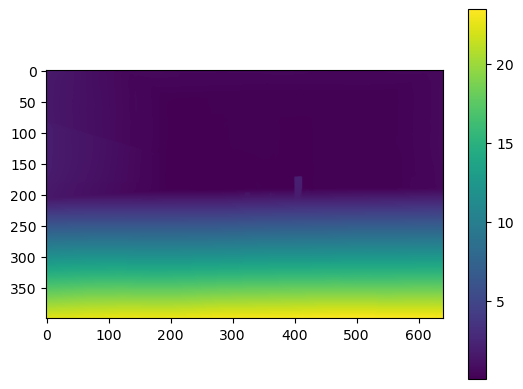

In [8]:
figure_show(np.load(r"D:\william\data\disp-refine\_feynman_camera_M1F0001222_leftir_image_rect_color\output\dam_v2_vitb_out.npy"))

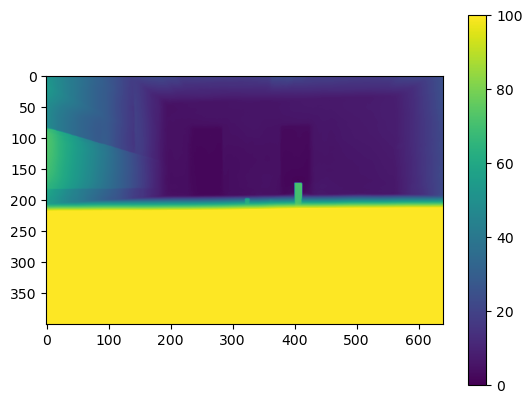

In [13]:
figure_show(np.load(r"D:\william\data\disp-refine\_feynman_camera_M1F0001222_leftir_image_rect_color\output\dam_v2_vitl_out.npy"), 0, 0, 100)

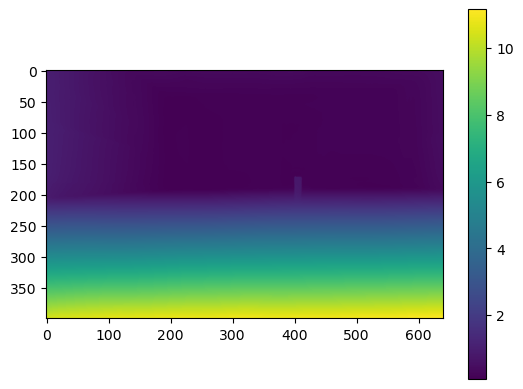

In [10]:
figure_show(np.load(r"D:\william\data\disp-refine\_feynman_camera_M1F0001222_leftir_image_rect_color\output\dam_v2_vits_out.npy"))

In [8]:
from cv2.ximgproc import GuidedFilter

In [9]:
# resize the source and target image for computation efficiency
full_agg = np.load('data/11/output_0222_agg.npy')
full_dl = np.load('data/11/output_0626_DLV2.npy')
scaled_agg = image_resize(full_agg, (full_agg.shape[0]//2, full_agg.shape[1]//2))
scaled_dl = image_resize(full_dl, (full_dl.shape[0]//2, full_dl.shape[1]//2))

# close_agg = op_area_closing(scaled_agg, 64, 1)
# close_agg = scaled_agg

# find the invalid pixels, and apply on dl result
insufficient_indices = np.where(scaled_agg <= 10)
dl = np.copy(scaled_dl)
dl[insufficient_indices] = 0

guided_res = cv2.ximgproc.guidedFilter(
        guide=scaled_dl.astype(np.float32), src=scaled_agg.astype(np.float32), radius=5, eps=10, dDepth=-1)

norm_agg, minv_agg, maxv_agg = minmax_normalizer(scaled_agg)
norm_dl, minv_dl, maxv_dl = minmax_normalizer(dl)
trans_agg = ot_transport_emd(norm_agg, norm_dl)
trans_agg_restore = restore_from_minmax(trans_agg, minv_agg, maxv_agg)

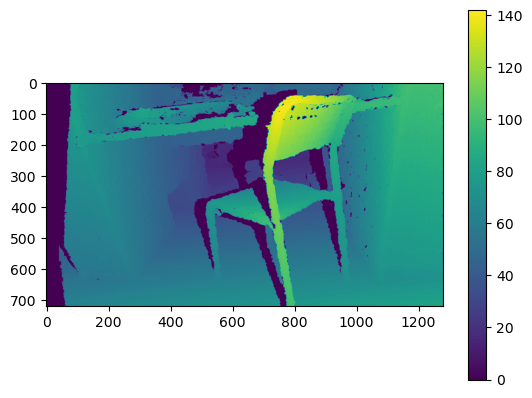

In [10]:
figure_show(full_agg)

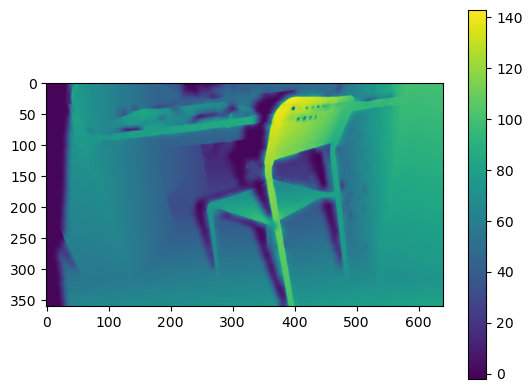

In [10]:
figure_show(guided_res)

In [11]:
guided_res

array([[ 0.      ,  0.      ,  0.      , ..., 99.70692 , 99.706665,
        99.9358  ],
       [ 0.      ,  0.      ,  0.      , ..., 99.693726, 99.70661 ,
        99.68695 ],
       [ 0.      ,  0.      ,  0.      , ..., 99.66006 , 99.65833 ,
        99.644646],
       ...,
       [ 0.      ,  0.      ,  0.      , ..., 81.15853 , 81.095535,
        81.01761 ],
       [ 0.      ,  0.      ,  0.      , ..., 81.11074 , 81.029785,
        80.931274],
       [ 0.      ,  0.      ,  0.      , ..., 81.01608 , 80.93204 ,
        80.8073  ]], dtype=float32)

In [70]:
gan = ConstrainedGAN(scaled_agg.shape)
gan.train(scaled_agg, dl, 3000)

Epoch 0, Loss D: 0.45128774642944336, Loss G: 100.0, Loss Similarity: 4309.5576171875
Epoch 10, Loss D: 7.114422192421381e-27, Loss G: 59.56342697143555, Loss Similarity: 4308.30224609375
Epoch 20, Loss D: 5.439946542650194e-24, Loss G: 52.875186920166016, Loss Similarity: 4307.26025390625
Epoch 30, Loss D: 5.1698765666344355e-20, Loss G: 43.71570587158203, Loss Similarity: 4307.50634765625
Epoch 40, Loss D: 9.389141685813528e-15, Loss G: 31.606075286865234, Loss Similarity: 4306.7021484375
Epoch 50, Loss D: 2.17744933195263e-09, Loss G: 19.251983642578125, Loss Similarity: 4306.66552734375
Epoch 60, Loss D: 0.00020838489581365138, Loss G: 9.770524024963379, Loss Similarity: 4306.83642578125
Epoch 70, Loss D: 1.7929365640156902e-05, Loss G: 10.653532981872559, Loss Similarity: 4306.2744140625
Epoch 80, Loss D: 1.7842152374214493e-05, Loss G: 10.730250358581543, Loss Similarity: 4305.92333984375
Epoch 90, Loss D: 1.668275763222482e-05, Loss G: 10.757070541381836, Loss Similarity: 4305.5

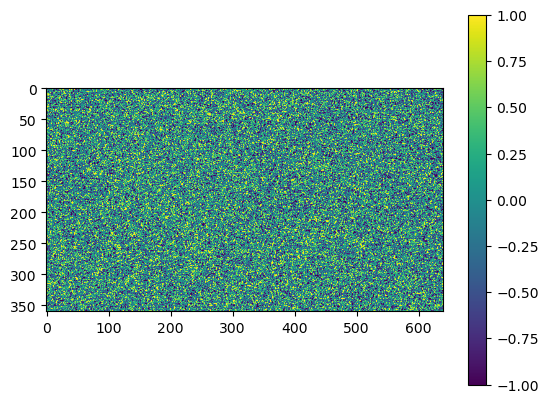

In [69]:
gan_res = gan.infer(norm_agg).squeeze(0)
figure_show(gan_res)

In [29]:
xs = torch.tensor(trans_agg_restore, dtype=torch.float32).unsqueeze(0).clone().detach().requires_grad_(True)
xt = torch.tensor(scaled_agg, dtype=torch.float32).unsqueeze(0)
xd = torch.tensor(scaled_dl, dtype=torch.float32).unsqueeze(0)


In [30]:
KLOptim = KLTripletOptimizer(xs, xt, xd, dist='kl', min_delta=1e-3)
KLOptim.weights_adjust(20000, 1)

Running on: cuda


In [31]:
KLOptim.train(2500)

100%|██████████| 2500/2500 [00:14<00:00, 171.52it/s]


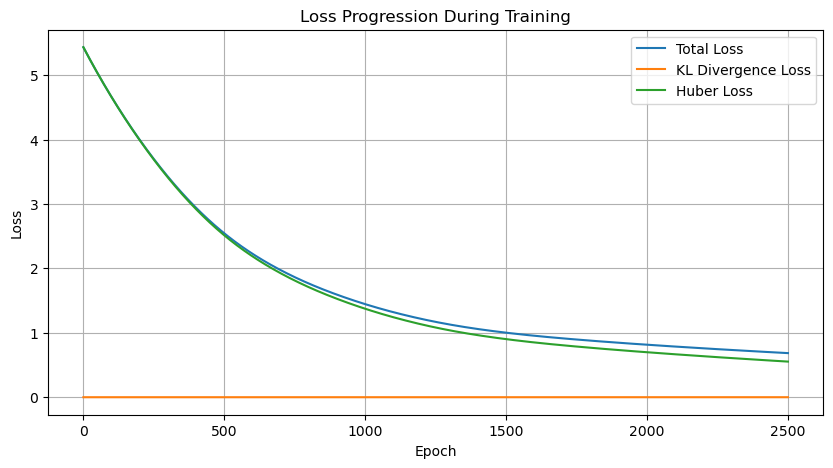

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(KLOptim.total_losses, label='Total Loss')
plt.plot(KLOptim.dist_losses, label='KL Divergence Loss')
plt.plot(KLOptim.huber_losses, label='Huber Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Progression During Training')
plt.legend()
plt.grid(True)
plt.show()

In [34]:
o_trans_agg = KLOptim.xs.cpu().squeeze(0).detach().numpy()
print(o_trans_agg.shape)

(360, 640)


In [35]:
o_trans_agg

array([[  0.     ,   0.     ,   0.     , ..., 100.46287, 100.53942,
        100.93851],
       [  0.     ,   0.     ,   0.     , ..., 100.23999, 100.08725,
        100.28774],
       [  0.     ,   0.     ,   0.     , ..., 100.04107, 100.04166,
        100.26506],
       ...,
       [  0.     ,   0.     ,   0.     , ...,  82.01005,  82.01052,
         81.96386],
       [  0.     ,   0.     ,   0.     , ...,  82.01125,  82.01105,
         80.09131],
       [  0.     ,   0.     ,   0.     , ...,  82.01262,  82.00704,
         63.79718]], dtype=float32)

In [36]:
scaled_agg

array([[  0.        ,   0.        ,   0.        , ..., 100.42274504,
        100.49986807, 100.91964125],
       [  0.        ,   0.        ,   0.        , ..., 100.1994897 ,
        100.04780228, 100.24728491],
       [  0.        ,   0.        ,   0.        , ..., 100.00005891,
        100.00008003, 100.22326241],
       ...,
       [  0.        ,   0.        ,   0.        , ...,  82.        ,
         81.9999859 ,  81.95229186],
       [  0.        ,   0.        ,   0.        , ...,  82.        ,
         81.99942978,  80.07014717],
       [  0.        ,   0.        ,   0.        , ...,  82.        ,
         81.99459219,  63.69788986]])

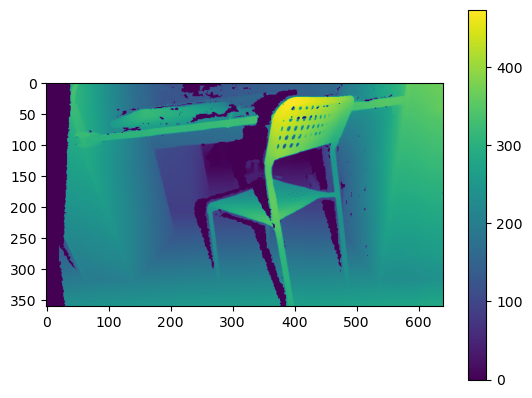

In [37]:
figure_show(dl)

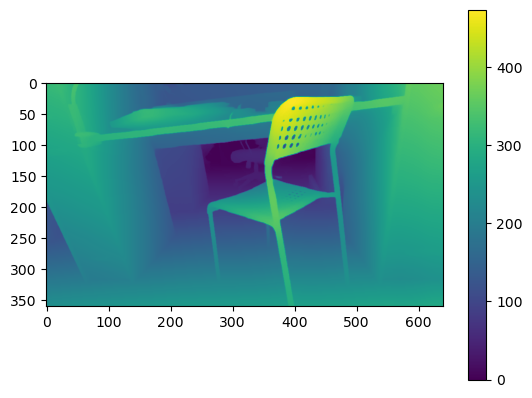

In [38]:
figure_show(scaled_dl)

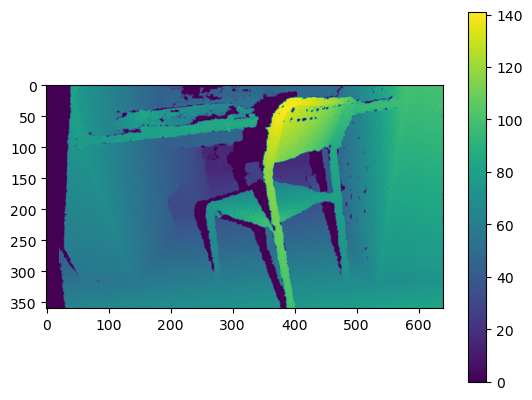

In [39]:
figure_show(scaled_agg)

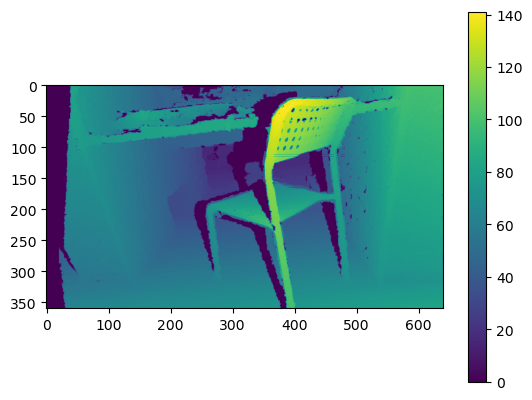

In [40]:
figure_show(o_trans_agg)

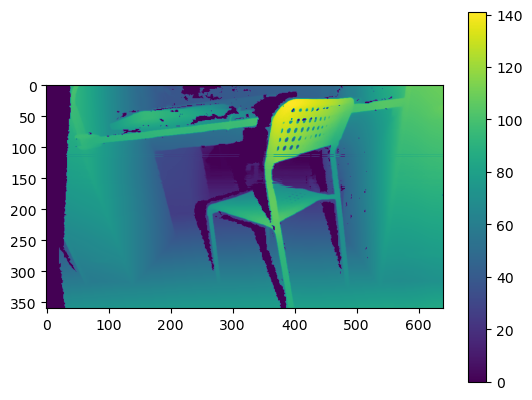

In [23]:
figure_show(trans_agg_restore)

In [95]:
trans_agg_restore

array([[  0.        ,   0.        ,   0.        , ..., 109.13954947,
        109.09256132, 105.01601385],
       [  0.        ,   0.        ,   0.        , ..., 108.99819843,
        108.6176457 , 109.03803456],
       [  0.        ,   0.        ,   0.        , ..., 108.90907979,
        109.03396691, 109.30589474],
       ...,
       [  0.        ,   0.        ,   0.        , ...,  84.18069937,
         84.28548353,  84.4615273 ],
       [  0.        ,   0.        ,   0.        , ...,  84.4413403 ,
         84.52160086,  84.66546477],
       [  0.        ,   0.        ,   0.        , ...,  84.7389431 ,
         84.69723282,  84.8507196 ]])

In [24]:
o_trans_agg

array([[  0.      ,   0.      ,   0.      , ..., 100.41947 , 100.49625 ,
        100.91511 ],
       [  0.      ,   0.      ,   0.      , ..., 100.197174, 100.04624 ,
        100.244705],
       [  0.      ,   0.      ,   0.      , ...,  99.9985  ,  99.998505,
        100.2206  ],
       ...,
       [  0.      ,   0.      ,   0.      , ...,  81.996155,  81.99583 ,
         81.94799 ],
       [  0.      ,   0.      ,   0.      , ...,  81.99592 ,  81.99496 ,
         80.07409 ],
       [  0.      ,   0.      ,   0.      , ...,  81.99547 ,  81.98969 ,
         63.776493]], dtype=float32)

In [25]:
scaled_agg

array([[  0.        ,   0.        ,   0.        , ..., 100.42274504,
        100.49986807, 100.91964125],
       [  0.        ,   0.        ,   0.        , ..., 100.1994897 ,
        100.04780228, 100.24728491],
       [  0.        ,   0.        ,   0.        , ..., 100.00005891,
        100.00008003, 100.22326241],
       ...,
       [  0.        ,   0.        ,   0.        , ...,  82.        ,
         81.9999859 ,  81.95229186],
       [  0.        ,   0.        ,   0.        , ...,  82.        ,
         81.99942978,  80.07014717],
       [  0.        ,   0.        ,   0.        , ...,  82.        ,
         81.99459219,  63.69788986]])

In [26]:
mu_diff1 = (o_trans_agg-scaled_agg).mean()
mu_diff1

0.0029615291600337632

In [27]:
mu_diff2 = (trans_agg_restore-scaled_agg).mean()
mu_diff2

0.14386885609554267

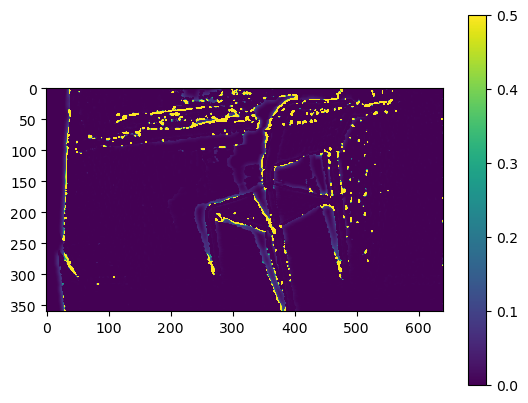

In [28]:
figure_show(o_trans_agg-scaled_agg, 0, 0, 0.5)

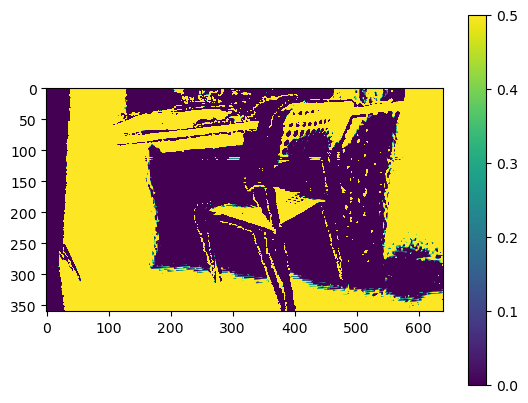

In [101]:
figure_show(trans_agg_restore-scaled_agg, 0, 0, 0.5)

In [115]:
KLOptim2 = KLTripletOptimizer(xs, xt, xd, dist='ks', min_delta=1e-3)
KLOptim2.weights_adjust(2, 1)

Running on: cuda


In [116]:
KLOptim2.train(2500)

100%|██████████| 2500/2500 [00:07<00:00, 328.73it/s]


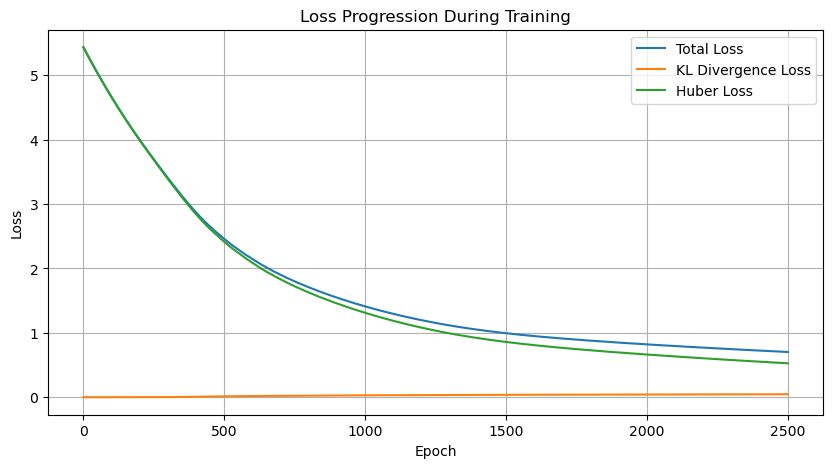

In [117]:
plt.figure(figsize=(10, 5))
plt.plot(KLOptim2.total_losses, label='Total Loss')
plt.plot(KLOptim2.dist_losses, label='KL Divergence Loss')
plt.plot(KLOptim2.huber_losses, label='Huber Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Progression During Training')
plt.legend()
plt.grid(True)
plt.show()

In [118]:
o_trans_agg = KLOptim2.xs.cpu().squeeze(0).detach().numpy()
print(o_trans_agg.shape)

(360, 640)


In [119]:
o_trans_agg

array([[  0.      ,   0.      ,   0.      , ..., 100.46572 , 100.54224 ,
        100.93985 ],
       [  0.      ,   0.      ,   0.      , ..., 100.242874, 100.09006 ,
        100.29063 ],
       [  0.      ,   0.      ,   0.      , ..., 100.04399 , 100.04462 ,
        100.26804 ],
       ...,
       [  0.      ,   0.      ,   0.      , ...,  82.01068 ,  82.0112  ,
         81.96464 ],
       [  0.      ,   0.      ,   0.      , ...,  82.012   ,  82.01184 ,
         80.09282 ],
       [  0.      ,   0.      ,   0.      , ...,  82.01351 ,  82.00792 ,
         63.80592 ]], dtype=float32)

In [120]:
scaled_agg

array([[  0.        ,   0.        ,   0.        , ..., 100.42274504,
        100.49986807, 100.91964125],
       [  0.        ,   0.        ,   0.        , ..., 100.1994897 ,
        100.04780228, 100.24728491],
       [  0.        ,   0.        ,   0.        , ..., 100.00005891,
        100.00008003, 100.22326241],
       ...,
       [  0.        ,   0.        ,   0.        , ...,  82.        ,
         81.9999859 ,  81.95229186],
       [  0.        ,   0.        ,   0.        , ...,  82.        ,
         81.99942978,  80.07014717],
       [  0.        ,   0.        ,   0.        , ...,  82.        ,
         81.99459219,  63.69788986]])

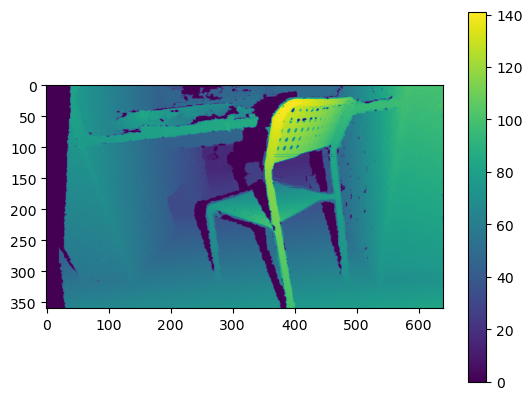

In [121]:
figure_show(o_trans_agg)

In [122]:
import gc

gc.collect()

68074

This is for the feynman experiments

In [10]:
import os
import numpy as np
import cv2

RAW_DISP = "disp.bin"
POST_DISP = "disp_postprocess.bin"
SAM_V2_VITL = "dam_v2_vitl_out.npy"
SAM_V2_VITB = "dam_v2_vitb_out.npy"
SAM_V2_VITS = "dam_v2_vits_out.npy"

In [11]:
def load_bin(path, h, w):
    return np.fromfile(path, dtype=np.uint16, count=h*w).reshape((h, w))

for folder near sight error

In [111]:
top_dir = "D:/william/data/disp-refine/near-faults"
# raw_disp = load_bin(os.path.join(top_dir, RAW_DISP), 480, 640) / 64
# post_disp = load_bin(os.path.join(top_dir, POST_DISP), 480, 640) / 64
raw_disp = cv2.imread(os.path.join(top_dir, "output_0911.png"), cv2.IMREAD_UNCHANGED) / 64
vitl_disp = np.load(os.path.join(top_dir, SAM_V2_VITL))
vitb_disp = np.load(os.path.join(top_dir, SAM_V2_VITB))
vits_disp = np.load(os.path.join(top_dir, SAM_V2_VITS))

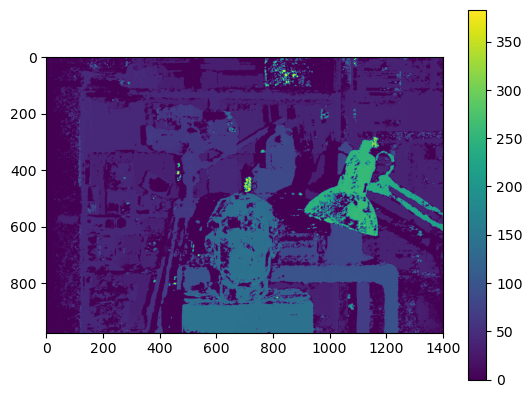

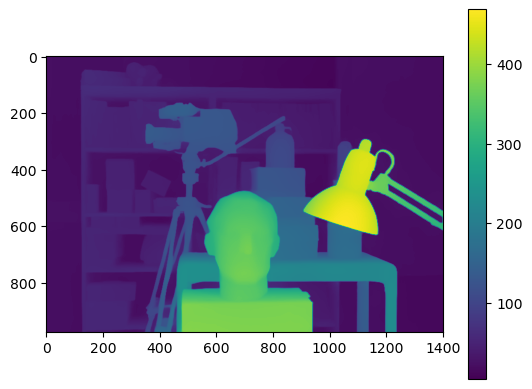

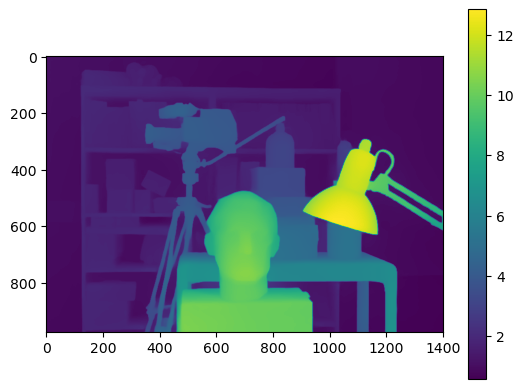

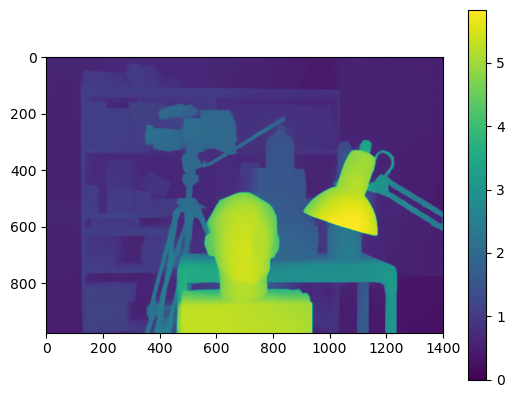

In [112]:
figure_show(raw_disp)
figure_show(vitl_disp)
figure_show(vitb_disp)
figure_show(vits_disp)

In [113]:
insufficient_indices = np.where(raw_disp == 0)
dl = np.copy(vitl_disp)
dl[insufficient_indices] = 0


norm_raw, minv_raw, maxv_raw = minmax_normalizer(raw_disp)
norm_vitl, minv_vitl, maxv_vitl = minmax_normalizer(dl)
optimal_t = ot_transport_emd(norm_raw, norm_vitl)
optimal_t_r = restore_from_minmax(optimal_t, minv_raw, maxv_raw)

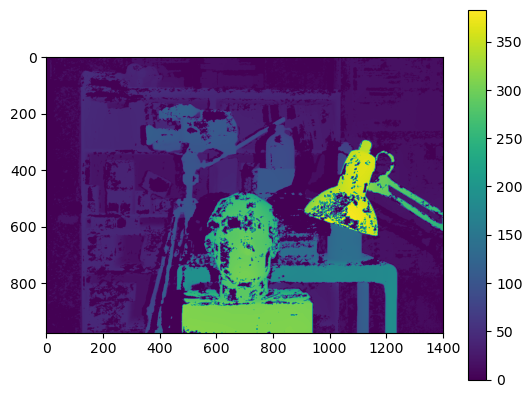

In [114]:
figure_show(optimal_t_r)

In [115]:
xs = torch.tensor(optimal_t_r, dtype=torch.float32).unsqueeze(0).clone().detach().requires_grad_(True)
xt = torch.tensor(raw_disp, dtype=torch.float32).unsqueeze(0)
xd = torch.tensor(dl, dtype=torch.float32).unsqueeze(0)

In [116]:
KLOptim = KLTripletOptimizer(xs, xt, xd, min_delta=1e-3)
KLOptim.weights_adjust(20000, 1)

Running on: cuda


In [117]:
KLOptim.train(3000)

100%|██████████| 3000/3000 [00:35<00:00, 84.78it/s]


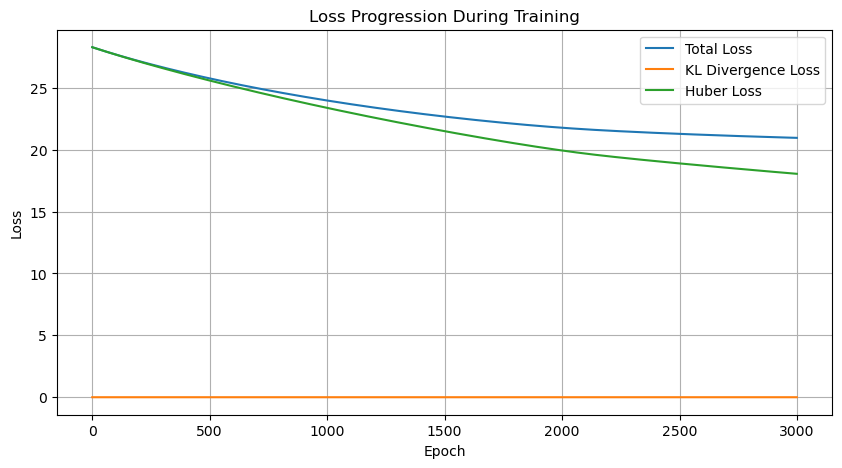

In [118]:
plt.figure(figsize=(10, 5))
plt.plot(KLOptim.total_losses, label='Total Loss')
plt.plot(KLOptim.kl_losses, label='KL Divergence Loss')
plt.plot(KLOptim.huber_losses, label='Huber Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Progression During Training')
plt.legend()
plt.grid(True)
plt.show()

In [119]:
o_t = KLOptim.xs.cpu().squeeze(0).detach().numpy()
print(o_t.shape)

(974, 1402)


In [120]:
o_t[o_t < 1] = 0
o_t

array([[ 0.      ,  0.      ,  0.      , ..., 34.49773 , 34.48198 ,
        34.46406 ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [ 0.      ,  0.      ,  0.      , ..., 26.578041,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ..., 14.907551,  0.      ,
         0.      ]], dtype=float32)

In [121]:
raw_disp

array([[ 0.,  0.,  0., ..., 35., 35., 35.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., 27.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 15.,  0.,  0.]])

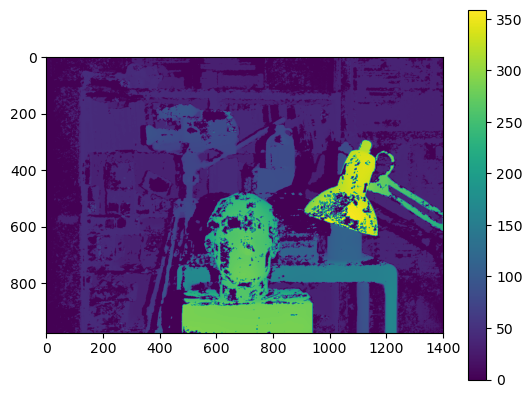

In [122]:
figure_show(o_t)

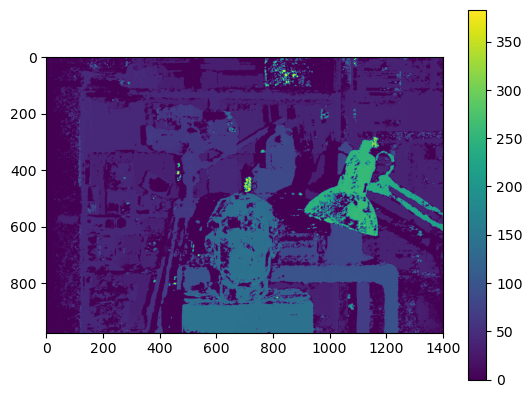

In [123]:
figure_show(raw_disp)

In [124]:
print(np.mean(raw_disp-o_t))

-13.54837817858806


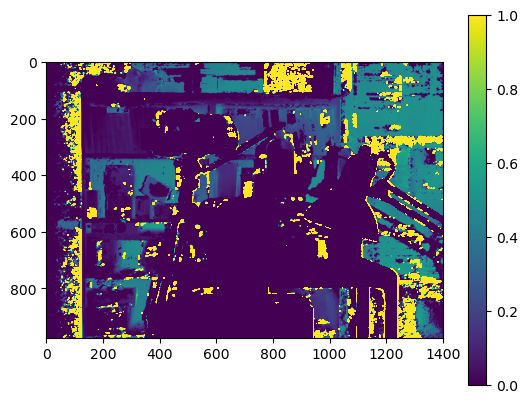

In [125]:
figure_show(raw_disp-o_t, 0, 0, 1)

In [67]:
import gc

gc.collect()

13495